In [1]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import Union, Tuple, List, Optional
from scipy.integrate import odeint
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

## Boucwen Data

In [261]:
class BoucWenSimulator:
    """
    Bouc-Wen 히스테리시스 모델 시뮬레이터
    
    Bouc-Wen 방정식:
    F = α*k*x + (1-α)*k*D*z
    dz/dt = (1/D) * [A*dx/dt - β|dx/dt||z|^(n-1)*z - γ*dx/dt*|z|^n]
    
    여기서:
    - F: 복원력 (restoring force)
    - x: 변위 (displacement)  
    - z: 히스테리시스 변수
    - α: 탄성 기여도 (0~1)
    - β, γ: 히스테리시스 형태 파라미터
    - n: 매끄러움 파라미터 (보통 1~2)
    - k: 강성
    - D: 특성 변위
    - A: 정규화 인자 (보통 1)
    """
    
    def __init__(self):
        self.default_params = {
            'alpha': 0.3,    # 탄성 기여도 0.3
            'beta': 0.5,     # 히스테리시스 형태 파라미터 1 0.5
            'gamma': 0.5,    # 히스테리시스 형태 파라미터 2 0.5
            'n': 1.0,        # 매끄러움 파라미터 0.5
            'k': 1.0,        # 강성 1
            'D': 1.5,        # 특성 변위 1
            'A': 1.0         # 정규화 인자 1
        }
    
    def bouc_wen_ode(self, state: np.ndarray, t: float, 
                     displacement: np.ndarray, time: np.ndarray,
                     alpha: float, beta: float, gamma: float, 
                     n: float, k: float, D: float, A: float) -> List[float]:
        """
        Bouc-Wen 미분방정식
        
        Args:
            state: [z] - 히스테리시스 변수
            t: 현재 시간
            displacement: 변위 시계열
            time: 시간 배열
            alpha, beta, gamma, n, k, D, A: Bouc-Wen 파라미터
        
        Returns:
            dz/dt
        """
        z = state[0]
        
        # 현재 시간에서의 변위와 속도 계산
        x = np.interp(t, time, displacement)
        
        # 속도 계산 (중앙차분법)
        dt = time[1] - time[0]
        idx = np.searchsorted(time, t)
        if idx == 0:
            dx_dt = (displacement[1] - displacement[0]) / dt
        elif idx >= len(displacement):
            dx_dt = (displacement[-1] - displacement[-2]) / dt
        else:
            dx_dt = (displacement[idx] - displacement[idx-1]) / dt
        
        # Bouc-Wen 방정식
        if abs(z) < 1e-10:  # 0 근처에서의 수치적 안정성
            z_term1 = 0
            z_term2 = 0
        else:
            z_term1 = beta * abs(dx_dt) * abs(z)**(n-1) * z
            z_term2 = gamma * dx_dt * abs(z)**n
        
        dzdt = (1/D) * (A * dx_dt - z_term1 - z_term2)
        
        return [dzdt]
    
    def simulate_constant_params(self, 
                               displacement: np.ndarray,
                               time: np.ndarray,
                               params: Optional[dict] = None,
                               z0: float = 0.0) -> Tuple[np.ndarray, np.ndarray]:
        """
        일정한 파라미터로 Bouc-Wen 시뮬레이션 (정상 데이터)
        
        Args:
            displacement: 입력 변위 시계열
            time: 시간 배열
            params: Bouc-Wen 파라미터 딕셔너리
            z0: 히스테리시스 변수 초기값
            
        Returns:
            force: 복원력 시계열
            z_history: 히스테리시스 변수 이력
        """
        if params is None:
            params = self.default_params.copy()
        
        # 미분방정식 해결
        z_solution = odeint(self.bouc_wen_ode, [z0], time, 
                           args=(displacement, time, 
                                params['alpha'], params['beta'], params['gamma'],
                                params['n'], params['k'], params['D'], params['A']))
        
        z_history = z_solution[:, 0]
        
        # 복원력 계산
        force = (params['alpha'] * params['k'] * displacement + 
                (1 - params['alpha']) * params['k'] * params['D'] * z_history)
        
        return force, z_history
    
    def simulate_varying_params(self,
                              displacement: np.ndarray,
                              time: np.ndarray,
                              param_trajectories: dict,
                              z0: float = 0.0) -> Tuple[np.ndarray, np.ndarray]:
        """
        시간에 따라 변화하는 파라미터로 Bouc-Wen 시뮬레이션 (불량 데이터)
        
        Args:
            displacement: 입력 변위 시계열
            time: 시간 배열
            param_trajectories: 시간에 따른 파라미터 변화 
                               예: {'alpha': [0.1, 0.1, 0.2, ...], 'beta': [...]}
            z0: 히스테리시스 변수 초기값
            
        Returns:
            force: 복원력 시계열
            z_history: 히스테리시스 변수 이력
        """
        n_steps = len(time)
        z_history = np.zeros(n_steps)
        force = np.zeros(n_steps)
        
        z_history[0] = z0
        
        # 시간 스텝별로 적분
        for i in range(1, n_steps):
            dt = time[i] - time[i-1]
            t_current = time[i-1]
            
            # 현재 시간의 파라미터 값들
            current_params = {}
            for param_name, trajectory in param_trajectories.items():
                current_params[param_name] = trajectory[i-1]
            
            # 기본값으로 누락된 파라미터 채우기
            for param_name, default_value in self.default_params.items():
                if param_name not in current_params:
                    current_params[param_name] = default_value
            
            # 한 스텝 적분
            z_solution = odeint(self.bouc_wen_ode, [z_history[i-1]], 
                               [t_current, time[i]], 
                               args=(displacement, time,
                                    current_params['alpha'], current_params['beta'], 
                                    current_params['gamma'], current_params['n'],
                                    current_params['k'], current_params['D'], 
                                    current_params['A']))
            
            z_history[i] = z_solution[-1, 0]
            
            # 복원력 계산
            force[i] = (current_params['alpha'] * current_params['k'] * displacement[i] + 
                       (1 - current_params['alpha']) * current_params['k'] * 
                       current_params['D'] * z_history[i])
        
        return force, z_history
    
    def generate_sinusoidal_displacement(self, 
                                       amplitude: float = 1.0,
                                       frequency: float = 1.0,
                                       duration: float = 10.0,
                                       sampling_rate: float = 100.0,
                                       phase: float = 0.0) -> Tuple[np.ndarray, np.ndarray]:
        """
        사인파 변위 생성
        
        Args:
            amplitude: 진폭
            frequency: 주파수 (Hz)
            duration: 지속시간 (초)
            sampling_rate: 샘플링 주파수 (Hz)
            phase: 위상 (라디안)
            
        Returns:
            time: 시간 배열
            displacement: 변위 배열
        """
        time = np.linspace(0, duration, int(duration * sampling_rate))
        displacement = amplitude * np.sin(2 * np.pi * frequency * time + phase)
        return time, displacement
    
    def create_fault_scenario(self,
                            fault_type: str,
                            time: np.ndarray,
                            transition_start_ratio: float = 0.7,
                            severity: float = 3.0) -> dict:
        """
        FMEA 기반 불량 시나리오 생성
        
        Args:
            fault_type: 불량 유형 ('stiffness_loss', 'damping_change', 'nonlinearity_increase', 'combined')
            time: 시간 배열
            transition_start_ratio: 불량 시작 시점 (전체 시간의 비율)
            severity: 불량 심각도 (변화 정도)
            
        Returns:
            param_trajectories: 시간에 따른 파라미터 변화
        """
        n_steps = len(time)
        transition_start = int(n_steps * transition_start_ratio)
        
        # 기본 파라미터로 초기화
        param_trajectories = {}
        for param_name, default_value in self.default_params.items():
            param_trajectories[param_name] = np.full(n_steps, default_value)
        
        # 불량 유형별 파라미터 변화 정의
        if fault_type == 'stiffness_loss':
            # 강성 손실: alpha 감소
            for i in range(transition_start, n_steps):
                progress = (i - transition_start) / (n_steps - transition_start)
                param_trajectories['alpha'][i] = self.default_params['alpha'] * (1 - progress * (severity - 1) / severity)
                
        elif fault_type == 'damping_change':
            # 감쇠 특성 변화: beta 증가
            for i in range(transition_start, n_steps):
                progress = (i - transition_start) / (n_steps - transition_start)
                param_trajectories['beta'][i] = self.default_params['beta'] * (1 + progress * (severity - 1))
                
        elif fault_type == 'nonlinearity_increase':
            # 비선형성 증가: gamma 증가
            for i in range(transition_start, n_steps):
                progress = (i - transition_start) / (n_steps - transition_start)
                param_trajectories['gamma'][i] = self.default_params['gamma'] * (1 + progress * (severity - 1))
                
        elif fault_type == 'combined':
            # 복합 불량: alpha 감소 + beta 증가
            for i in range(transition_start, n_steps):
                progress = (i - transition_start) / (n_steps - transition_start)
                param_trajectories['alpha'][i] = self.default_params['alpha'] * (1 - progress * 0.5)
                param_trajectories['beta'][i] = self.default_params['beta'] * (1 + progress * (severity - 1))
        
        return param_trajectories
    
    def plot_hysteresis_loop(self, displacement: np.ndarray, force: np.ndarray, 
                           title: str = "Hysteresis Loop"):
        """히스테리시스 루프 플롯"""
        plt.figure(figsize=(8, 6))
        plt.plot(displacement, force, 'b-', linewidth=2)
        plt.xlabel('Displacement')
        plt.ylabel('Force')
        plt.title(title)
        plt.grid(True, alpha=0.3)
        plt.axis('equal')
        plt.show()
    
    def plot_time_series(self, time: np.ndarray, displacement: np.ndarray, 
                        force: np.ndarray, z_history: np.ndarray,
                        param_trajectories: Optional[dict] = None):
        """시계열 데이터 플롯"""
        fig, axes = plt.subplots(2, 2, figsize=(12, 8))
        
        # 변위
        axes[0, 0].plot(time, displacement, 'b-')
        axes[0, 0].set_title('Displacement')
        axes[0, 0].set_xlabel('Time')
        axes[0, 0].grid(True, alpha=0.3)
        
        # 복원력
        axes[0, 1].plot(time, force, 'r-')
        axes[0, 1].set_title('Force')
        axes[0, 1].set_xlabel('Time')
        axes[0, 1].grid(True, alpha=0.3)
        
        # 히스테리시스 변수
        axes[1, 0].plot(time, z_history, 'g-')
        axes[1, 0].set_title('Hysteresis Variable (z)')
        axes[1, 0].set_xlabel('Time')
        axes[1, 0].grid(True, alpha=0.3)
        
        # 파라미터 변화 (있는 경우)
        if param_trajectories:
            for param_name, trajectory in param_trajectories.items():
                if param_name in ['alpha', 'beta', 'gamma']:  # 주요 파라미터만
                    axes[1, 1].plot(time, trajectory, label=param_name)
            axes[1, 1].set_title('Parameter Evolution')
            axes[1, 1].set_xlabel('Time')
            axes[1, 1].legend()
            axes[1, 1].grid(True, alpha=0.3)
        else:
            axes[1, 1].text(0.5, 0.5, 'Constant Parameters', 
                           ha='center', va='center', transform=axes[1, 1].transAxes)
            axes[1, 1].set_title('Parameter Evolution')
        
        plt.tight_layout()
        plt.show()

In [262]:
simulator = BoucWenSimulator()

In [269]:
time, displacement = simulator.generate_sinusoidal_displacement(
    amplitude=2.0, frequency=2, duration=10
)

In [270]:
force_normal, z_normal = simulator.simulate_constant_params(displacement, time)

In [271]:
fault_params = simulator.create_fault_scenario('damping_change', time, transition_start_ratio=0.7, severity=5)

In [272]:
force_fault, z_fault = simulator.simulate_varying_params(displacement, time, fault_params)

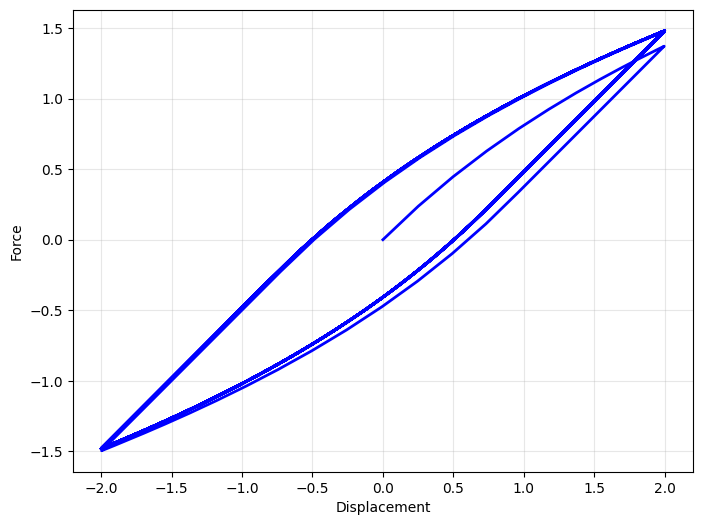

In [273]:
simulator.plot_hysteresis_loop(displacement, force_normal, title="")

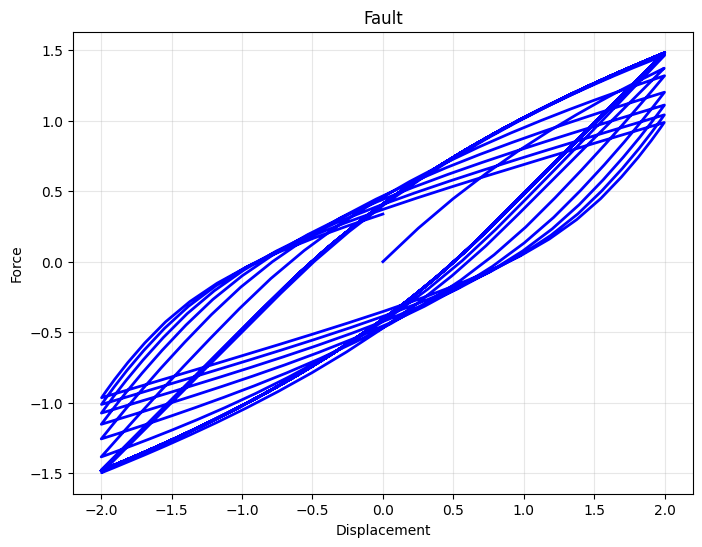

In [274]:
simulator.plot_hysteresis_loop(displacement, force_fault, title="Fault")

## PI-VAE model

In [10]:
class HysteresisDataset(Dataset):
    """히스테리시스 곡선 데이터셋"""
    def __init__(self, 
                 displacement_data: np.ndarray, 
                 force_data: np.ndarray,
                 fault_labels: np.ndarray,
                 param_data: Optional[np.ndarray] = None):
        self.displacement = torch.FloatTensor(displacement_data)
        self.force = torch.FloatTensor(force_data)
        self.fault_labels = torch.LongTensor(fault_labels)
        
        if param_data is not None:
            self.params = torch.FloatTensor(param_data)
        else:
            self.params = None
            
        # 입력 데이터: displacement와 force를 결합
        self.input_data = torch.stack([self.displacement, self.force], dim=-1)
        
    def __len__(self):
        return len(self.displacement)
    
    def __getitem__(self, idx):
        item = {
            'input': self.input_data[idx],
            'displacement': self.displacement[idx],
            'force': self.force[idx],
            'fault_label': self.fault_labels[idx]
        }
        
        if self.params is not None:
            item['params'] = self.params[idx]
            
        return item

In [11]:
class MultiHeadAttention(nn.Module):
    """Multi-Head Attention 모듈"""
    def __init__(self, d_model: int, n_heads: int, dropout: float = 0.1):
        super().__init__()
        assert d_model % n_heads == 0
        
        self.d_model = d_model
        self.n_heads = n_heads
        self.d_k = d_model // n_heads
        
        self.w_q = nn.Linear(d_model, d_model)
        self.w_k = nn.Linear(d_model, d_model)
        self.w_v = nn.Linear(d_model, d_model)
        self.w_o = nn.Linear(d_model, d_model)
        
        self.dropout = nn.Dropout(dropout)
        self.scale = math.sqrt(self.d_k)
        
    def forward(self, query, key, value, mask=None):
        batch_size, seq_len = query.size(0), query.size(1)
        
        Q = self.w_q(query).view(batch_size, seq_len, self.n_heads, self.d_k).transpose(1, 2)
        K = self.w_k(key).view(batch_size, seq_len, self.n_heads, self.d_k).transpose(1, 2)
        V = self.w_v(value).view(batch_size, seq_len, self.n_heads, self.d_k).transpose(1, 2)
        
        scores = torch.matmul(Q, K.transpose(-2, -1)) / self.scale
        
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
            
        attn_weights = F.softmax(scores, dim=-1)
        attn_weights = self.dropout(attn_weights)
        
        context = torch.matmul(attn_weights, V)
        context = context.transpose(1, 2).contiguous().view(batch_size, seq_len, self.d_model)
        
        output = self.w_o(context)
        return output, attn_weights

In [12]:
class PositionalEncoding(nn.Module):
    """Positional Encoding for Transformer"""
    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * 
                           (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + self.pe[:x.size(1), :].transpose(0, 1)
        return self.dropout(x)

In [13]:
class AttentionEncoder(nn.Module):
    """Attention 기반 Encoder"""
    def __init__(self, 
                 input_dim: int = 2,
                 d_model: int = 256,
                 n_heads: int = 8,
                 n_layers: int = 6,
                 latent_dim: int = 64,
                 dropout: float = 0.1):
        super().__init__()
        
        self.input_projection = nn.Linear(input_dim, d_model)
        self.pos_encoding = PositionalEncoding(d_model, dropout)
        
        self.attention_layers = nn.ModuleList([
            nn.ModuleDict({
                'attention': MultiHeadAttention(d_model, n_heads, dropout),
                'norm1': nn.LayerNorm(d_model),
                'ffn': nn.Sequential(
                    nn.Linear(d_model, d_model * 4),
                    nn.GELU(),
                    nn.Dropout(dropout),
                    nn.Linear(d_model * 4, d_model)
                ),
                'norm2': nn.LayerNorm(d_model),
                'dropout': nn.Dropout(dropout)
            }) for _ in range(n_layers)
        ])
        
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        
        # Latent space projection
        self.feature_extractor = nn.Sequential(
            nn.Linear(d_model, 512),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(512, 256),
            nn.GELU(),
            nn.Dropout(dropout)
        )
        
        self.mu_layer = nn.Linear(256, latent_dim)
        self.logvar_layer = nn.Linear(256, latent_dim)
        
    def forward(self, x):
        batch_size, seq_len = x.size(0), x.size(1)
        
        x = self.input_projection(x)
        x = self.pos_encoding(x)
        
        for layer in self.attention_layers:
            attn_out, _ = layer['attention'](x, x, x)
            x = layer['norm1'](x + layer['dropout'](attn_out))
            
            ffn_out = layer['ffn'](x)
            x = layer['norm2'](x + layer['dropout'](ffn_out))
        
        x = x.transpose(1, 2)
        x = self.global_pool(x).squeeze(-1)
        
        features = self.feature_extractor(x)
        mu = self.mu_layer(features)
        logvar = self.logvar_layer(features)
        
        return mu, logvar

In [14]:
class AttentionDecoder(nn.Module):
    """Attention 기반 Decoder"""
    def __init__(self,
                 latent_dim: int = 64,
                 d_model: int = 256,
                 n_heads: int = 8,
                 n_layers: int = 6,
                 output_dim: int = 2,
                 seq_len: int = 1000,
                 dropout: float = 0.1):
        super().__init__()
        
        self.seq_len = seq_len
        self.d_model = d_model
        
        self.latent_expansion = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(256, 512),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(512, d_model * seq_len)
        )
        
        self.pos_encoding = PositionalEncoding(d_model, dropout)
        
        self.attention_layers = nn.ModuleList([
            nn.ModuleDict({
                'attention': MultiHeadAttention(d_model, n_heads, dropout),
                'norm1': nn.LayerNorm(d_model),
                'ffn': nn.Sequential(
                    nn.Linear(d_model, d_model * 4),
                    nn.GELU(),
                    nn.Dropout(dropout),
                    nn.Linear(d_model * 4, d_model)
                ),
                'norm2': nn.LayerNorm(d_model),
                'dropout': nn.Dropout(dropout)
            }) for _ in range(n_layers)
        ])
        
        self.output_projection = nn.Sequential(
            nn.Linear(d_model, 128),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(128, output_dim)
        )
        
    def forward(self, z):
        batch_size = z.size(0)
        
        x = self.latent_expansion(z)
        x = x.view(batch_size, self.seq_len, self.d_model)
        x = self.pos_encoding(x)
        
        for layer in self.attention_layers:
            attn_out, _ = layer['attention'](x, x, x)
            x = layer['norm1'](x + layer['dropout'](attn_out))
            
            ffn_out = layer['ffn'](x)
            x = layer['norm2'](x + layer['dropout'](ffn_out))
        
        output = self.output_projection(x)
        return output

In [15]:
class BoucWenPhysicsLoss(nn.Module):
    """실제 Bouc-Wen 방정식 기반 물리 손실 함수"""
    def __init__(self, dt: float = 0.01, default_params: dict = None):
        super().__init__()
        self.dt = dt
        
        if default_params is None:
            self.default_params = {
                'alpha': 0.1,
                'beta': 0.5, 
                'gamma': 0.5,
                'n': 1.0,
                'k': 1.0,
                'D': 1.0,
                'A': 1.0
            }
        else:
            self.default_params = default_params
    
    def compute_velocity(self, displacement):
        """중앙차분법으로 속도 계산"""
        batch_size, seq_len = displacement.shape
        velocity = torch.zeros_like(displacement)
        
        # 경계 조건
        velocity[:, 0] = (displacement[:, 1] - displacement[:, 0]) / self.dt
        velocity[:, -1] = (displacement[:, -1] - displacement[:, -2]) / self.dt
        
        # 중앙차분법
        velocity[:, 1:-1] = (displacement[:, 2:] - displacement[:, :-2]) / (2 * self.dt)
        
        return velocity
    
    def compute_z_derivative(self, velocity, z, params=None):
        """
        Bouc-Wen 방정식에 따른 dz/dt 계산
        dz/dt = (1/D) * [A*dx/dt - β|dx/dt||z|^(n-1)*z - γ*dx/dt*|z|^n]
        """
        if params is None:
            # 기본 파라미터 사용
            alpha = self.default_params['alpha']
            beta = self.default_params['beta']
            gamma = self.default_params['gamma']
            n = self.default_params['n']
            D = self.default_params['D']
            A = self.default_params['A']
        else:
            # 시간에 따라 변하는 파라미터 (불량 케이스)
            alpha = params['alpha']
            beta = params['beta']
            gamma = params['gamma']
            n = params['n']
            D = params['D']
            A = params['A']
        
        # 수치적 안정성을 위한 작은 값
        eps = 1e-8
        
        # |z|^(n-1) * z 계산 (sign preservation)
        z_abs = torch.abs(z) + eps
        z_power_term1 = torch.sign(z) * torch.pow(z_abs, n - 1) * z
        
        # |z|^n 계산
        z_power_term2 = torch.pow(z_abs, n)
        
        # Bouc-Wen 방정식
        term1 = A * velocity
        term2 = beta * torch.abs(velocity) * z_power_term1
        term3 = gamma * velocity * z_power_term2
        
        dzdt = (1 / D) * (term1 - term2 - term3)
        
        return dzdt
    
    def integrate_z(self, velocity, z_initial=None, params=None):
        """오일러 방법으로 z 적분"""
        batch_size, seq_len = velocity.shape
        
        if z_initial is None:
            z = torch.zeros_like(velocity)
        else:
            z = torch.zeros_like(velocity)
            z[:, 0] = z_initial
        
        # 시간 스텝별 적분
        for i in range(1, seq_len):
            if params is not None and len(params['alpha'].shape) > 1:
                # 시간에 따라 변하는 파라미터
                current_params = {
                    'alpha': params['alpha'][:, i-1],
                    'beta': params['beta'][:, i-1],
                    'gamma': params['gamma'][:, i-1],
                    'n': params['n'][:, i-1],
                    'D': params['D'][:, i-1],
                    'A': params['A'][:, i-1]
                }
            else:
                current_params = params
                
            dzdt = self.compute_z_derivative(velocity[:, i-1:i], z[:, i-1:i], current_params)
            z[:, i] = z[:, i-1] + dzdt.squeeze() * self.dt
        
        return z
    
    def compute_force_from_bw(self, displacement, z, params=None):
        """Bouc-Wen 방정식으로 복원력 계산"""
        if params is None:
            alpha = self.default_params['alpha']
            k = self.default_params['k']
            D = self.default_params['D']
        else:
            if len(params['alpha'].shape) > 1:
                # 시간에 따라 변하는 파라미터
                alpha = params['alpha']
                k = params['k']
                D = params['D']
            else:
                alpha = params['alpha']
                k = params['k']
                D = params['D']
        
        # F = α*k*x + (1-α)*k*D*z
        elastic_force = alpha * k * displacement
        hysteretic_force = (1 - alpha) * k * D * z
        
        return elastic_force + hysteretic_force
    
    def forward(self, displacement, force, params=None):
        """물리 일관성 손실 계산"""
        # 속도 계산
        velocity = self.compute_velocity(displacement)
        
        # z 적분
        z_predicted = self.integrate_z(velocity, params=params)
        
        # 예측된 복원력 계산
        force_predicted = self.compute_force_from_bw(displacement, z_predicted, params)
        
        # 물리 손실: 예측된 복원력과 실제 복원력 간의 차이
        physics_loss = F.mse_loss(force_predicted, force)
        
        # 추가 물리 제약 조건들
        # 1. 에너지 일관성
        power = force * velocity
        energy_loss = torch.mean(torch.abs(torch.sum(power, dim=1)))
        
        # 2. z의 물리적 범위 제약 (-2 < z < 2 정도)
        z_constraint_loss = torch.mean(F.relu(torch.abs(z_predicted) - 3.0))
        
        total_physics_loss = physics_loss + 0.1 * energy_loss + 0.1 * z_constraint_loss
        
        return total_physics_loss, {
            'physics_loss': physics_loss,
            'energy_loss': energy_loss,
            'z_constraint_loss': z_constraint_loss,
            'z_predicted': z_predicted,
            'force_predicted': force_predicted
        }


In [16]:
class PhysicsInformedVAE(nn.Module):
    """Physics-informed VAE with Multiple Latent Distributions"""
    def __init__(self,
                 input_dim: int = 2,
                 latent_dim: int = 64,
                 n_fault_types: int = 4,
                 d_model: int = 256,
                 n_heads: int = 8,
                 n_layers: int = 6,
                 seq_len: int = 1000,
                 dropout: float = 0.1):
        super().__init__()
        
        self.latent_dim = latent_dim
        self.n_fault_types = n_fault_types
        self.seq_len = seq_len
        
        # Encoder
        self.encoder = AttentionEncoder(
            input_dim=input_dim,
            d_model=d_model,
            n_heads=n_heads,
            n_layers=n_layers,
            latent_dim=latent_dim,
            dropout=dropout
        )
        
        # Decoder
        self.decoder = AttentionDecoder(
            latent_dim=latent_dim,
            d_model=d_model,
            n_heads=n_heads,
            n_layers=n_layers,
            output_dim=input_dim,
            seq_len=seq_len,
            dropout=dropout
        )
        
        # Fault type classifier
        self.fault_classifier = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, n_fault_types)
        )
        
        # Multiple prior distributions (learnable)
        self.register_parameter('prior_mus', 
                              nn.Parameter(torch.randn(n_fault_types, latent_dim) * 0.1))
        self.register_parameter('prior_logvars', 
                              nn.Parameter(torch.zeros(n_fault_types, latent_dim)))
        
    def reparameterize(self, mu, logvar):
        """Reparameterization trick"""
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def forward(self, x, fault_labels=None):
        # Encode
        mu, logvar = self.encoder(x)
        
        # Reparameterize
        z = self.reparameterize(mu, logvar)
        
        # Classify fault type
        fault_logits = self.fault_classifier(z)
        
        # Decode
        recon = self.decoder(z)
        
        return {
            'reconstruction': recon,
            'mu': mu,
            'logvar': logvar,
            'z': z,
            'fault_logits': fault_logits
        }

In [17]:
def kl_divergence_multi_dist(mu, logvar, fault_labels, model):
    """다중 분포에 대한 KL divergence"""
    batch_size = mu.size(0)
    total_kl = 0
    
    for i in range(model.n_fault_types):
        mask = (fault_labels == i)
        if mask.sum() > 0:
            mu_batch = mu[mask]
            logvar_batch = logvar[mask]
            
            prior_mu = model.prior_mus[i]
            prior_logvar = model.prior_logvars[i]
            
            # KL(q(z|x) || p(z))
            kl = -0.5 * torch.sum(
                1 + logvar_batch - prior_logvar.unsqueeze(0) - 
                (logvar_batch.exp() + (mu_batch - prior_mu.unsqueeze(0)).pow(2)) / 
                prior_logvar.exp().unsqueeze(0),
                dim=1
            )
            total_kl += kl.mean()
    
    return total_kl / model.n_fault_types

In [18]:
seq_len = 1000
latent_dim = 64
n_fault_type = 4
batch_size = 16
epochs = 200
learning_rate = 1e-4
dt = 0.01

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [20]:
model = PhysicsInformedVAE(
    input_dim=2,
    latent_dim=latent_dim,
    n_fault_types=n_fault_type,
    d_model=256,
    n_heads=8,
    n_layers=6,
    seq_len=seq_len,
    dropout=0.1
).to(device)

In [21]:
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.5)

In [22]:
recon_loss_fn = nn.MSELoss()
fault_loss_fn = nn.CrossEntropyLoss()
physics_loss_fn = BoucWenPhysicsLoss(dt=dt)

In [23]:
recon_weight = 1.0
kl_weight = 0.1
fault_weight = 0.5
physics_weight = 1.0


In [24]:
train_history = []

In [25]:
def generate_dataset_for_vae(simulator, 
                           n_normal: int = 1000,
                           n_fault_per_type: int = 300,
                           seq_len: int = 1000,
                           duration: float = 10.0,
                           sampling_rate: float = 100.0):
    """
    VAE 학습용 완전한 Bouc-Wen 데이터셋 생성
    
    Args:
        simulator: BoucWenSimulator 인스턴스
        n_normal: 정상 데이터 개수
        n_fault_per_type: 불량 유형별 데이터 개수
        seq_len: 시퀀스 길이
        duration: 시뮬레이션 지속시간 (초)
        sampling_rate: 샘플링 주파수 (Hz)
    
    Returns:
        displacement_data: (N, seq_len) 변위 데이터
        force_data: (N, seq_len) 복원력 데이터  
        fault_labels: (N,) 불량 유형 라벨 (0: 정상, 1,2,3,4: 불량 유형)
        param_data: (N, seq_len, 7) 파라미터 데이터
    """
    
    print("=== VAE 학습용 Bouc-Wen 데이터셋 생성 시작 ===")
    
    all_displacement = []
    all_force = []
    all_params = []
    all_labels = []
    
    # =========================
    # 1. 정상 데이터 생성
    # =========================
    print(f"정상 데이터 {n_normal}개 생성 중...")
    
    # 정상 상태용 파라미터 범위 정의 (다양한 정상 조건)
    param_ranges = {
        'alpha': [0.05, 0.3],     # 탄성 기여도
        'beta': [0.2, 1.0],       # 히스테리시스 형태 파라미터 1  
        'gamma': [0.2, 1.0],      # 히스테리시스 형태 파라미터 2
        'n': [1.0, 2.0],          # 매끄러움 파라미터
        'k': [0.5, 2.0],          # 강성
        'D': [0.8, 1.5],          # 특성 변위
        'A': [0.8, 1.2]           # 정규화 인자
    }
    
    for i in tqdm(range(n_normal), desc="정상 데이터 생성"):
        # 랜덤한 정상 파라미터 조합 생성
        params = {}
        for param_name, (min_val, max_val) in param_ranges.items():
            params[param_name] = np.random.uniform(min_val, max_val)
        
        # 다양한 입력 신호 생성
        amplitude = np.random.uniform(1.0, 3.0)
        frequency = np.random.uniform(0.3, 1.5)
        phase = np.random.uniform(0, 2*np.pi)
        
        time, displacement = simulator.generate_sinusoidal_displacement(
            amplitude=amplitude,
            frequency=frequency, 
            duration=duration,
            sampling_rate=sampling_rate,
            phase=phase
        )
        
        # 길이 조정
        displacement, time = adjust_sequence_length(displacement, time, seq_len, duration)
        
        # 시뮬레이션 실행
        force, z_history = simulator.simulate_constant_params(displacement, time, params)
        
        # 파라미터 궤적 생성 (일정한 값)
        param_trajectory = create_constant_param_trajectory(params, seq_len)
        
        all_displacement.append(displacement)
        all_force.append(force)
        all_params.append(param_trajectory)
        all_labels.append(0)  # 정상: 0
    
    # =========================
    # 2. 불량 데이터 생성
    # =========================
    fault_types = ['stiffness_loss', 'damping_change', 'nonlinearity_increase', 'combined']
    fault_type_mapping = {
        'stiffness_loss': 1,
        'damping_change': 2,
        'nonlinearity_increase': 3,
        'combined': 4
    }
    
    for fault_type in fault_types:
        print(f"{fault_type} 불량 데이터 {n_fault_per_type}개 생성 중...")
        
        for i in tqdm(range(n_fault_per_type), desc=f"{fault_type} 데이터 생성"):
            # 다양한 입력 신호 생성
            amplitude = np.random.uniform(1.0, 3.0)
            frequency = np.random.uniform(0.3, 1.5)
            phase = np.random.uniform(0, 2*np.pi)
            
            time, displacement = simulator.generate_sinusoidal_displacement(
                amplitude=amplitude,
                frequency=frequency,
                duration=duration,
                sampling_rate=sampling_rate,
                phase=phase
            )
            
            # 길이 조정
            displacement, time = adjust_sequence_length(displacement, time, seq_len, duration)
            
            # 불량 시나리오 생성 (파라미터 변경)
            transition_start_ratio = np.random.uniform(0.2, 0.5)  # 불량 시작 시점 랜덤화
            severity = np.random.uniform(1.5, 4.0)  # 불량 심각도 랜덤화
            
            param_trajectories = simulator.create_fault_scenario(
                fault_type=fault_type,
                time=time,
                transition_start_ratio=transition_start_ratio,
                severity=severity
            )
            
            # 시뮬레이션 실행
            force, z_history = simulator.simulate_varying_params(
                displacement, time, param_trajectories
            )
            
            # 파라미터 궤적을 배열로 변환
            param_trajectory = convert_param_dict_to_array(param_trajectories, seq_len)
            
            all_displacement.append(displacement)
            all_force.append(force)
            all_params.append(param_trajectory)
            all_labels.append(fault_type_mapping[fault_type])
    
    # =========================
    # 3. 데이터 변환 및 정리
    # =========================
    print("데이터 변환 및 정리 중...")
    
    # numpy 배열로 변환
    displacement_data = np.array(all_displacement)  # (N, seq_len)
    force_data = np.array(all_force)                # (N, seq_len)
    fault_labels = np.array(all_labels)             # (N,)
    param_data = np.array(all_params)               # (N, seq_len, 7)
    
    # 데이터 셔플
    n_total = len(displacement_data)
    shuffle_idx = np.random.permutation(n_total)
    
    displacement_data = displacement_data[shuffle_idx]
    force_data = force_data[shuffle_idx]
    fault_labels = fault_labels[shuffle_idx]
    param_data = param_data[shuffle_idx]
    
    print(f"\n=== 데이터셋 생성 완료 ===")
    print(f"총 데이터 개수: {n_total}")
    print(f"정상 데이터: {n_normal}개")
    print(f"불량 데이터: {len(fault_types) * n_fault_per_type}개")
    print(f"데이터 형태:")
    print(f"  - displacement_data: {displacement_data.shape}")
    print(f"  - force_data: {force_data.shape}")
    print(f"  - fault_labels: {fault_labels.shape}")
    print(f"  - param_data: {param_data.shape}")
    
    # 라벨 분포 확인
    unique_labels, counts = np.unique(fault_labels, return_counts=True)
    print(f"\n라벨 분포:")
    label_names = ['정상', '강성손실', '감쇠변화', '비선형증가', '복합불량']
    for label, count in zip(unique_labels, counts):
        print(f"  {label_names[label]}: {count}개")
    
    return displacement_data, force_data, fault_labels, param_data

In [26]:
def adjust_sequence_length(displacement, time, target_length, duration):
    """시퀀스 길이를 목표 길이로 조정"""
    current_length = len(displacement)
    
    if current_length > target_length:
        # 다운샘플링
        displacement = displacement[:target_length]
        time = time[:target_length]
    elif current_length < target_length:
        # 업샘플링 (보간)
        time_new = np.linspace(0, duration, target_length)
        displacement = np.interp(time_new, time, displacement)
        time = time_new
    
    return displacement, time

def create_constant_param_trajectory(params, seq_len):
    """일정한 파라미터를 시간에 따른 궤적으로 변환"""
    param_names = ['alpha', 'beta', 'gamma', 'n', 'k', 'D', 'A']
    trajectory = np.zeros((seq_len, len(param_names)))
    
    for i, param_name in enumerate(param_names):
        trajectory[:, i] = params[param_name]
    
    return trajectory

def convert_param_dict_to_array(param_trajectories, seq_len):
    """파라미터 딕셔너리를 배열로 변환"""
    param_names = ['alpha', 'beta', 'gamma', 'n', 'k', 'D', 'A']
    trajectory = np.zeros((seq_len, len(param_names)))
    
    for i, param_name in enumerate(param_names):
        trajectory[:, i] = param_trajectories[param_name]
    
    return trajectory


In [27]:
displacement_data, force_data, fault_labels, param_data = generate_dataset_for_vae(
    simulator=simulator,
    n_normal=800,           # 정상 데이터 800개
    n_fault_per_type=200,   # 불량 유형별 200개씩
    seq_len=1000,          # 시퀀스 길이 1000
    duration=10.0,         # 10초 시뮬레이션
    sampling_rate=100.0    # 100Hz 샘플링
)


=== VAE 학습용 Bouc-Wen 데이터셋 생성 시작 ===
정상 데이터 800개 생성 중...


정상 데이터 생성: 100%|██████████| 800/800 [04:27<00:00,  2.99it/s]


stiffness_loss 불량 데이터 200개 생성 중...


stiffness_loss 데이터 생성: 100%|██████████| 200/200 [01:25<00:00,  2.35it/s]


damping_change 불량 데이터 200개 생성 중...


damping_change 데이터 생성: 100%|██████████| 200/200 [01:24<00:00,  2.38it/s]


nonlinearity_increase 불량 데이터 200개 생성 중...


nonlinearity_increase 데이터 생성: 100%|██████████| 200/200 [01:24<00:00,  2.36it/s]


combined 불량 데이터 200개 생성 중...


combined 데이터 생성: 100%|██████████| 200/200 [01:24<00:00,  2.36it/s]

데이터 변환 및 정리 중...

=== 데이터셋 생성 완료 ===
총 데이터 개수: 1600
정상 데이터: 800개
불량 데이터: 800개
데이터 형태:
  - displacement_data: (1600, 1000)
  - force_data: (1600, 1000)
  - fault_labels: (1600,)
  - param_data: (1600, 1000, 7)

라벨 분포:
  정상: 800개
  강성손실: 200개
  감쇠변화: 200개
  비선형증가: 200개
  복합불량: 200개


In [32]:
displacement_data.shape

(1600, 1000)

In [34]:
force_data.shape

(1600, 1000)

In [28]:
dataset = HysteresisDataset(displacement_data, force_data, fault_labels, param_data)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


In [44]:
torch.isnan(dataset.params).any()

tensor(False)

In [29]:
for epoch in range(epochs):
    model.train()
    epoch_losses = {
        'total_loss': 0, 'recon_loss': 0, 'kl_loss': 0, 
        'fault_loss': 0, 'physics_loss': 0, 'energy_loss': 0,
        'z_constraint_loss': 0
    }
    
    for batch_idx, batch in enumerate(dataloader):
        optimizer.zero_grad()
        
        # 데이터를 device로 이동
        x = batch['input'].to(device)
        fault_labels = batch['fault_label'].to(device)
        displacement = batch['displacement'].to(device)
        force = batch['force'].to(device)
        
        # 파라미터 데이터 처리 (수정된 부분)
        params = None
        if 'params' in batch and batch['params'] is not None:
            if isinstance(batch['params'], dict):
                # 딕셔너리 형태인 경우
                params = {k: v.to(device) for k, v in batch['params'].items()}
            elif isinstance(batch['params'], torch.Tensor):
                # 텐서 형태인 경우 (batch_size, seq_len, n_params)
                param_tensor = batch['params'].to(device)
                param_names = ['alpha', 'beta', 'gamma', 'n', 'k', 'D', 'A']
                params = {}
                for i, param_name in enumerate(param_names):
                    params[param_name] = param_tensor[:, :, i]
            else:
                # 파라미터가 없거나 다른 형태인 경우
                params = None
        
        # Forward pass
        outputs = model(x, fault_labels)
        
        # 1. Reconstruction Loss
        recon_loss = recon_loss_fn(outputs['reconstruction'], x)
        
        # 2. KL Divergence Loss (다중 분포)
        kl_loss = kl_divergence_multi_dist(outputs['mu'], outputs['logvar'], fault_labels, model)
        
        # 3. Fault Classification Loss
        fault_loss = fault_loss_fn(outputs['fault_logits'], fault_labels)
        
        # 4. Physics Loss (실제 Bouc-Wen 방정식)
        try:
            physics_loss, physics_details = physics_loss_fn(displacement, force, params)
        except Exception as e:
            print(f"Physics loss 계산 중 오류: {e}")
            # Physics loss 계산에 실패한 경우 기본값 사용
            physics_loss = torch.tensor(0.0, device=device, requires_grad=True)
            physics_details = {
                'physics_loss': physics_loss,
                'energy_loss': torch.tensor(0.0, device=device),
                'z_constraint_loss': torch.tensor(0.0, device=device)
            }
        
        # Total Loss
        total_loss = (recon_weight * recon_loss + 
                     kl_weight * kl_loss + 
                     fault_weight * fault_loss + 
                     physics_weight * physics_loss)
        
        # Backward pass
        total_loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        # 손실 누적
        epoch_losses['total_loss'] += total_loss.item()
        epoch_losses['recon_loss'] += recon_loss.item()
        epoch_losses['kl_loss'] += kl_loss.item()
        epoch_losses['fault_loss'] += fault_loss.item()
        
        # Physics details 안전하게 처리
        if isinstance(physics_details['physics_loss'], torch.Tensor):
            epoch_losses['physics_loss'] += physics_details['physics_loss'].item()
        else:
            epoch_losses['physics_loss'] += physics_details['physics_loss']
            
        if isinstance(physics_details['energy_loss'], torch.Tensor):
            epoch_losses['energy_loss'] += physics_details['energy_loss'].item()
        else:
            epoch_losses['energy_loss'] += physics_details['energy_loss']
            
        if isinstance(physics_details['z_constraint_loss'], torch.Tensor):
            epoch_losses['z_constraint_loss'] += physics_details['z_constraint_loss'].item()
        else:
            epoch_losses['z_constraint_loss'] += physics_details['z_constraint_loss']
        
        # 주기적 로그 출력
        if batch_idx % 50 == 0:
            physics_loss_val = physics_details['physics_loss'].item() if isinstance(physics_details['physics_loss'], torch.Tensor) else physics_details['physics_loss']
            print(f"Epoch {epoch+1}/{epochs}, Batch {batch_idx}: "
                  f"Total Loss = {total_loss.item():.6f}, "
                  f"Physics Loss = {physics_loss_val:.6f}, "
                  f"Recon Loss = {recon_loss.item():.6f}")
        
        # 메모리 정리 (선택적)
        if batch_idx % 100 == 0:
            torch.cuda.empty_cache() if torch.cuda.is_available() else None
    
    # 에포크 평균 손실 계산
    num_batches = len(dataloader)
    for key in epoch_losses:
        epoch_losses[key] /= num_batches
    
    # Learning rate scheduling
    scheduler.step(epoch_losses['total_loss'])

Physics loss 계산 중 오류: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.



RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
